<a href="https://colab.research.google.com/github/cullenjamieson/Group5_repos/blob/main/2D_Ideal_Training_Size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import softmax
import PIL.Image
import os
import torchvision
import cv2

from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import glob
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install albumentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [ ]:
class UNet(nn.Module): #from https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 1x128x128
        self.e11 = nn.Conv2d(1, 64, kernel_size=3,padding=1)
        self.bn11 = nn.BatchNorm2d(64) # batch normalization
        self.e12 = nn.Conv2d(64, 64, kernel_size=3,padding=1)
        self.bn12 = nn.BatchNorm2d(64) # batch normalization
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #64x64x64

        self.e21 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.bn21 = nn.BatchNorm2d(128) # batch normalization
        self.e22 = nn.Conv2d(128, 128, kernel_size=3,padding=1)
        self.bn22 = nn.BatchNorm2d(128) # batch normalization
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #32x32x128

        self.e31 = nn.Conv2d(128, 256, kernel_size=3,padding=1)
        self.bn31 = nn.BatchNorm2d(256) # batch normalization
        self.e32 = nn.Conv2d(256, 256, kernel_size=3,padding=1)
        self.bn32 = nn.BatchNorm2d(256) # batch normalization
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #16x16x256

        self.e41 = nn.Conv2d(256, 512, kernel_size=3,padding=1)
        self.bn41 = nn.BatchNorm2d(512) # batch normalization
        self.e42 = nn.Conv2d(512, 512, kernel_size=3,padding=1)
        self.bn42 = nn.BatchNorm2d(512) # batch normalization
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #8x8x512

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3,padding=1)
        self.bn51 = nn.BatchNorm2d(1024) # batch normalization
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3,padding=1)
        self.bn52 = nn.BatchNorm2d(1024) # batch normalization

        self.dropout = nn.Dropout(0.5)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #16x16x1024
        self.d11 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.d12 = nn.Conv2d(512,512,kernel_size=3,padding=1)

        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2) #
        self.d21 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.d22 = nn.Conv2d(256,256,kernel_size=3,padding=1)

        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.d31 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.d32 = nn.Conv2d(128,128,kernel_size=3,padding=1)

        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.d41 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.d42 = nn.Conv2d(64,64,kernel_size=3,padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.bn11(self.e11(x)))
        xe12 = F.relu(self.bn12(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        #xp1 = self.dropout(xp1) # dropout
        xe21 = F.relu(self.bn21(self.e21(xp1)))
        xe22 = F.relu(self.bn22(self.e22(xe21)))
        xp2 = self.pool2(xe22)

        xp2 = self.dropout(xp2) # dropout
        xe31 = F.relu(self.bn31(self.e31(xp2)))
        xe32 = F.relu(self.bn32(self.e32(xe31)))
        xp3 = self.pool3(xe32)

        xp3 = self.dropout(xp3) # dropout
        xe41 = F.relu(self.bn41(self.e41(xp3)))
        xe42 = F.relu(self.bn42(self.e42(xe41)))
        xp4 = self.pool4(xe42)

        xp4 = self.dropout(xp4) # dropout
        xe51 = F.relu(self.bn51(self.e51(xp4)))
        xe52 = F.relu(self.bn52(self.e52(xe51)))

        # Up-convolutions
        xup1 = self.upconv1(xe52)
        xup1 = self.dropout(xup1) # dropout
        xcat = torch.cat([xup1, xe42], dim=1)
        #xcat=xup1

        xup21 = F.relu(self.d11(xcat))
        xup22 = F.relu(self.d12(xup21))

        xup2 = self.upconv2(xup22)
        xup2 = self.dropout(xup2) # dropout
        #xcat2 = torch.cat([xup2, xe32[:,:,:-1,:-1]], dim=1)
        xcat2 = torch.cat([xup2, xe32], dim=1)
        #xcat2=xup2


        xup31 = F.relu(self.d21(xcat2))
        xup32 = F.relu(self.d22(xup31))
        xup3 = self.upconv3(xup32)
        #xup3 = self.dropout(xup3) # dropout
        xcat3 = torch.cat([xup3, xe22], dim=1)
        #xcat3=xup3

        xup41 = F.relu(self.d31(xcat3))
        xup42 = F.relu(self.d32(xup41))

        xup4 = self.upconv4(xup42)
        #xup4 = self.dropout(xup4) # dropout
        #xcat4 = torch.cat([xup4, xe12[:,:,2:-3,2:-3]], dim=1)
        xcat4 = torch.cat([xup4, xe12], dim=1)
        #xcat4=xup4

        xup51 = F.relu(self.d41(xcat4))
        xup52 = F.relu(self.d42(xup51))

        out = self.outconv(xup52)

        #output = softmax(out, dim=1)
        output=out
        return output

In [ ]:
#Setting up hyper parameters, from exercise week 6


loss_fn =  nn.CrossEntropyLoss()         # <-- Your code here.

import random


In [ ]:
test_size=0.35
batch_size = 16

training_idx, test_idx = train_test_split(
    range(300),
    test_size=test_size,
    random_state=42
)


val_idx, test_idx = train_test_split(
    test_idx,
    test_size=0.5,
    random_state=42
)


In [ ]:
training_file_names=[]
label_train_names=[]
for i in range(len(training_idx)):
  if len(str(training_idx[i]))<2:
    training_file_names.append('SOCprist000'+str(training_idx[i])+'.tiff')
    label_train_names.append('slice__00'+str(training_idx[i])+'.tif')
  if len(str(training_idx[i]))==2:
    training_file_names.append('SOCprist00'+str(training_idx[i])+'.tiff')
    label_train_names.append('slice__0'+str(training_idx[i])+'.tif')
  else:
    training_file_names.append('SOCprist0'+str(training_idx[i])+'.tiff')
    label_train_names.append('slice__'+str(training_idx[i])+'.tif')

In [ ]:
test_file_names=[]
label_test_names=[]
for i in range(len(test_idx)):
  if len(str(test_idx[i]))<2:
    test_file_names.append('SOCprist000'+str(test_idx[i])+'.tiff')
    label_test_names.append('slice__00'+str(test_idx[i])+'.tif')
  if len(str(test_idx[i]))==2:
    test_file_names.append('SOCprist00'+str(test_idx[i])+'.tiff')
    label_test_names.append('slice__0'+str(test_idx[i])+'.tif')
  else:
    test_file_names.append('SOCprist0'+str(test_idx[i])+'.tiff')
    label_test_names.append('slice__'+str(test_idx[i])+'.tif')

In [ ]:
val_file_names=[]
label_val_names=[]
for i in range(len(val_idx)):
  if len(str(val_idx[i]))<2:
    val_file_names.append('SOCprist000'+str(val_idx[i])+'.tiff')
    label_val_names.append('slice__00'+str(val_idx[i])+'.tif')
  if len(str(val_idx[i]))==2:
    val_file_names.append('SOCprist00'+str(val_idx[i])+'.tiff')
    label_val_names.append('slice__0'+str(val_idx[i])+'.tif')
  else:
    val_file_names.append('SOCprist0'+str(val_idx[i])+'.tiff')
    label_val_names.append('slice__'+str(val_idx[i])+'.tif')

In [ ]:
class Trainingdataset(Dataset):
    def __init__(self, root_dir, transform=None,file_names=None,label_names=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.transform = transform
        self.file_names= file_names
        self.label_names= label_names

        self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f in self.file_names])
        self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f in self.file_names])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])

      number1=img_name[-8:-5] #make sure the label fits with the image
      label_name=os.path.join(self.label_folder,'slice__'+str(number1)+'.tif')

      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)

      image=np.array(image)
      label=np.array(label)

      if self.transform is not None:
        augmentations=self.transform(image=image,mask=label)

      image=augmentations["image"]
      label=augmentations["mask"]

      return image, label

In [ ]:

transform = A.Compose(
    [
     #A.HorizontalFlip(p=0.3),
     A.RandomCrop(width=128, height=128),
     #A.VerticalFlip(p=0.1),
     #A.RandomBrightnessContrast(p=0.05),  # Adjust brightness/contrast
     A.GaussNoise(p=0.05),  # Add Gaussian noise
     #A.Resize(64, 64, p=0.2),  # Downsample to 64x64
     #A.Resize(128, 128),  # Upsample back to 128x128
     A.Normalize(
        mean=[0.5],
        std=[0.5],
        max_pixel_value=255.0,
     ),
     ToTensorV2(),
    ]
)

#The transformations from test only consist of normalization and to tensor transform
transform_val = A.Compose(
    [
     A.Normalize(
        mean=[0.5],
        std=[0.5],
        max_pixel_value=255.0,
     ),
     ToTensorV2(),
    ]
)



In [ ]:
SOC_dataset_train = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform,file_names=training_file_names,label_names=label_train_names)
SOC_dataset_test = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform,file_names=test_file_names,label_names=label_test_names)
SOC_dataset_val = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform_val,file_names=val_file_names,label_names=label_val_names)

In [ ]:
pip install torchmetrics

In [ ]:
from torchmetrics.classification import JaccardIndex
from torchmetrics.functional.classification import dice
from torchmetrics.classification import MulticlassAccuracy

In [ ]:
test_size=0.3
batch_size = 16

#train_loader = DataLoader(Subset(SOC_dataset, training_idx), batch_size=batch_size, shuffle=True,drop_last=False)
#test_loader = DataLoader(Subset(SOC_dataset, test_idx), batch_size=batch_size,drop_last=True)
#val_loader = DataLoader(SOC_dataset_label, batch_size=batch_size,drop_last=True)

train_loader = DataLoader(SOC_dataset_train, batch_size=batch_size, shuffle=True,drop_last=False)
test_loader = DataLoader(SOC_dataset_test, batch_size=batch_size,drop_last=True)
val_loader = DataLoader(SOC_dataset_val, batch_size=batch_size,drop_last=True)


In [ ]:
'''
This function evaluates the model on a validation set.
It calculates the
    - Dice coefficient,
    - Jaccard index,
    - pixel-wise accuracy for the model's predictions
'''
def evaluate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode

    # Initialize metrics
    total_dice = 0
    total_jaccard = 0
    total_pixel_accuracy = 0
    num_batches = 0

    with torch.no_grad():  # No need to track gradients
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert targets according to unique values
            un_target = targets.unique()
            targets[targets == un_target[0]] = 0
            targets[targets == un_target[1]] = 1
            targets[targets == un_target[2]] = 2
            targets = targets.to(torch.int64)

            # Get predictions
            predictions = outputs.max(1)[1]

            # Update metrics
            total_dice += dice(predictions, targets).item()
            total_jaccard += jaccard(predictions, targets).item()
            total_pixel_accuracy += accuracy(predictions, targets).item()
            num_batches += 1

    # Calculate average metrics
    avg_dice = total_dice / num_batches
    avg_jaccard = total_jaccard / num_batches
    avg_pixel_accuracy = total_pixel_accuracy / num_batches

    return avg_dice, avg_jaccard, avg_pixel_accuracy

In [ ]:
# #Code is inspired by exercise 4.2-EXE-CNN-CIFAR-10.ipynb
net=UNet(n_class=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.0001) #choosing the Adam optimizzer

#Defining the different accuracy metrics
jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
accuracy=MulticlassAccuracy(num_classes=3).to(device)
batch_size = 16 #batchsize
num_epochs = 50
validation_every_steps = np.ceil(len(train_loader.dataset)/batch_size) #How often the validation should be

step = 0
net.train()

train_accuracies_jaccard = []
train_accuracies_dice = []
train_accuracies_pixel = []
valid_accuracies_jaccard = []
valid_accuracies_dice = []
valid_accuracies_pixel = []
loss_epochs=[]
test_losses=[]
loss_train=[]
test_loss=[]


# Define the range for the number of images
num_images_options = [100, 200, 300, 400, 500]

# Initialize a structure to store results
results = []

for num_images in num_images_options:
    print(f"Training with {num_images} images")

    test_size=0.35
    batch_size = 16

    training_idx, test_idx = train_test_split(
        range(num_images),
        test_size=test_size,
        random_state=42
    )


    val_idx, test_idx = train_test_split(
        test_idx,
        test_size=0.5,
        random_state=42
    )

    training_file_names=[]
    label_train_names=[]
    for i in range(len(training_idx)):
      if len(str(training_idx[i]))<2:
        training_file_names.append('SOCprist000'+str(training_idx[i])+'.tiff')
        label_train_names.append('slice__00'+str(training_idx[i])+'.tif')
      if len(str(training_idx[i]))==2:
        training_file_names.append('SOCprist00'+str(training_idx[i])+'.tiff')
        label_train_names.append('slice__0'+str(training_idx[i])+'.tif')
      else:
        training_file_names.append('SOCprist0'+str(training_idx[i])+'.tiff')
        label_train_names.append('slice__'+str(training_idx[i])+'.tif')

    test_file_names=[]
    label_test_names=[]
    for i in range(len(test_idx)):
      if len(str(test_idx[i]))<2:
        test_file_names.append('SOCprist000'+str(test_idx[i])+'.tiff')
        label_test_names.append('slice__00'+str(test_idx[i])+'.tif')
      if len(str(test_idx[i]))==2:
        test_file_names.append('SOCprist00'+str(test_idx[i])+'.tiff')
        label_test_names.append('slice__0'+str(test_idx[i])+'.tif')
      else:
        test_file_names.append('SOCprist0'+str(test_idx[i])+'.tiff')
        label_test_names.append('slice__'+str(test_idx[i])+'.tif')

    val_file_names=[]
    label_val_names=[]
    for i in range(len(val_idx)):
      if len(str(val_idx[i]))<2:
        val_file_names.append('SOCprist000'+str(val_idx[i])+'.tiff')
        label_val_names.append('slice__00'+str(val_idx[i])+'.tif')
      if len(str(val_idx[i]))==2:
        val_file_names.append('SOCprist00'+str(val_idx[i])+'.tiff')
        label_val_names.append('slice__0'+str(val_idx[i])+'.tif')
      else:
        val_file_names.append('SOCprist0'+str(val_idx[i])+'.tiff')
        label_val_names.append('slice__'+str(val_idx[i])+'.tif')

    SOC_dataset_train = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform,file_names=training_file_names,label_names=label_train_names)
    SOC_dataset_test = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform,file_names=test_file_names,label_names=label_test_names)
    SOC_dataset_val = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform_val,file_names=val_file_names,label_names=label_val_names)

    # Initialize Data Loaders

    train_loader = DataLoader(SOC_dataset_train, batch_size=batch_size, shuffle=True,drop_last=False)
    test_loader = DataLoader(SOC_dataset_test, batch_size=batch_size,drop_last=True)
    val_loader = DataLoader(SOC_dataset_val, batch_size=batch_size,drop_last=True)

    # Reinitialize the model and optimizer
    net = UNet(n_class=3)
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    for epoch in range(num_epochs):
        train_accuracies_batches_jaccard = []
        train_accuracies_batches_dice = []
        train_accuracies_batches_pixel = []
        loss_epochs=[]

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass.
            output = net(inputs)

            #Divide targets into classes: [0,1,2]
            un_target=targets.unique()
            targets[targets==un_target[0]]=0
            targets[targets==un_target[1]]=1
            targets[targets==un_target[2]]=2

            targets = targets.to(torch.int64)

            #compute loss function
            loss = loss_fn(output, targets)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            step += 1

            # Compute accuracy.
            predictions = torch.argmax(output,dim=1) #Prediction with max of softmax output
            train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
            train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
            train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())
            loss_epochs.append(loss.detach().cpu().numpy())
            if step % validation_every_steps == 0:

                # Append average training accuracy to list.
                train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
                train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
                train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))
                loss_train.append(np.mean(loss_epochs))

                train_accuracies_batches_jaccard = []
                train_accuracies_batches_dice = []
                train_accuracies_batches_pixel = []

                # Compute accuracies on validation set.
                valid_accuracies_batches_jaccard = []
                valid_accuracies_batches_dice = []
                valid_accuracies_batches_pixel = []
                test_losses=[]
                with torch.no_grad():
                    net.eval()
                    for inputs, targets in test_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        output = net(inputs)

                        un_target=targets.unique()
                        # Compute loss.
                        targets[targets==un_target[0]]=0
                        targets[targets==un_target[1]]=1
                        targets[targets==un_target[2]]=2

                        targets = targets.to(torch.int64)

                        loss = loss_fn(output, targets)

                        predictions = output.max(1)[1]
                        valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                        valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                        valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())
                        test_losses.append(loss.cpu())
                    net.train()

                # Append average validation accuracy to list.
                valid_accuracies_jaccard.append(np.sum(valid_accuracies_batches_jaccard) / len(test_loader))
                valid_accuracies_dice.append(np.sum(valid_accuracies_batches_dice) / len(test_loader))
                valid_accuracies_pixel.append(np.sum(valid_accuracies_batches_pixel) / len(test_loader))
                test_loss.append(np.mean(test_losses))

                print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
                print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
                print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
                print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
                print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
                print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")
                print(f"             loss in test: {test_loss[-1]}")

    # Evaluate the model
    #avg_dice, avg_jaccard, avg_pixel_accuracy = evaluate_model(net, val_loader, device)
    avg_dice=valid_accuracies_dice[-1]
    avg_jaccard=valid_accuracies_jaccard[-1]
    avg_pixel=valid_accuracies_pixel[-1]

    # Store results
    results.append((num_images, avg_dice, avg_jaccard, avg_pixel))

print("Finished training.")

Training with 100 images
Step 13      training accuracy with jaccard: 0.8152146339416504
             training accuracy with dice: 0.888952910900116
             training accuracy with pixel by pixel: 0.9052643179893494
             test accuracy with jaccard: 0.4720611870288849
             test accuracy with dice: 0.6152534484863281
             test accuracy with pixel by pixel: 0.6281179189682007
             loss in test: 1.0336487293243408
Step 26      training accuracy with jaccard: 0.9444715976715088
             training accuracy with dice: 0.9710121154785156
             training accuracy with pixel by pixel: 0.9728684425354004
             test accuracy with jaccard: 0.27194130420684814
             test accuracy with dice: 0.5347633361816406
             test accuracy with pixel by pixel: 0.44010990858078003
             loss in test: 1.650853157043457
Step 39      training accuracy with jaccard: 0.8710352778434753
             training accuracy with dice: 0.928971290588378

In [ ]:
def plot_results(results):
    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=["Num Images", "Dice", "Jaccard", "Pixel Accuracy"])

    # Reshape the DataFrame for easier plotting
    df_melted = df.melt(id_vars=["Num Images"], value_vars=["Dice", "Jaccard", "Pixel Accuracy"],
                        var_name="Metric", value_name="Accuracy")

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_melted, x="Num Images", y="Accuracy", hue="Metric", marker="o")
    plt.title("2D Accuracy Metrics vs. Number of Images", fontsize=20)
    plt.ylabel("Accuracy", fontsize=17)
    plt.xlabel("Number of Images", fontsize=17)
    plt.legend(title="Metric", fontsize=17)
    plt.grid(True)
    plt.show()




In [ ]:
print(results)

[(100, 0.9861793518066406, 0.9731137752532959, 0.9860332012176514), (200, 0.9886608123779297, 0.977088212966919, 0.9883610606193542), (300, 0.9887034098307291, 0.9779033660888672, 0.9882882436116537), (400, 0.9892282485961914, 0.9785178303718567, 0.9897750616073608), (500, 0.9895469665527343, 0.9792641639709473, 0.9900459289550781)]


In [ ]:
results = [(100, 0.9861793518066406, 0.9731137752532959, 0.9860332012176514), (200, 0.9886608123779297, 0.977088212966919, 0.9883610606193542), (300, 0.9887034098307291, 0.9779033660888672, 0.9882882436116537), (400, 0.9892282485961914, 0.9785178303718567, 0.9897750616073608), (500, 0.9895469665527343, 0.9792641639709473, 0.9900459289550781)]


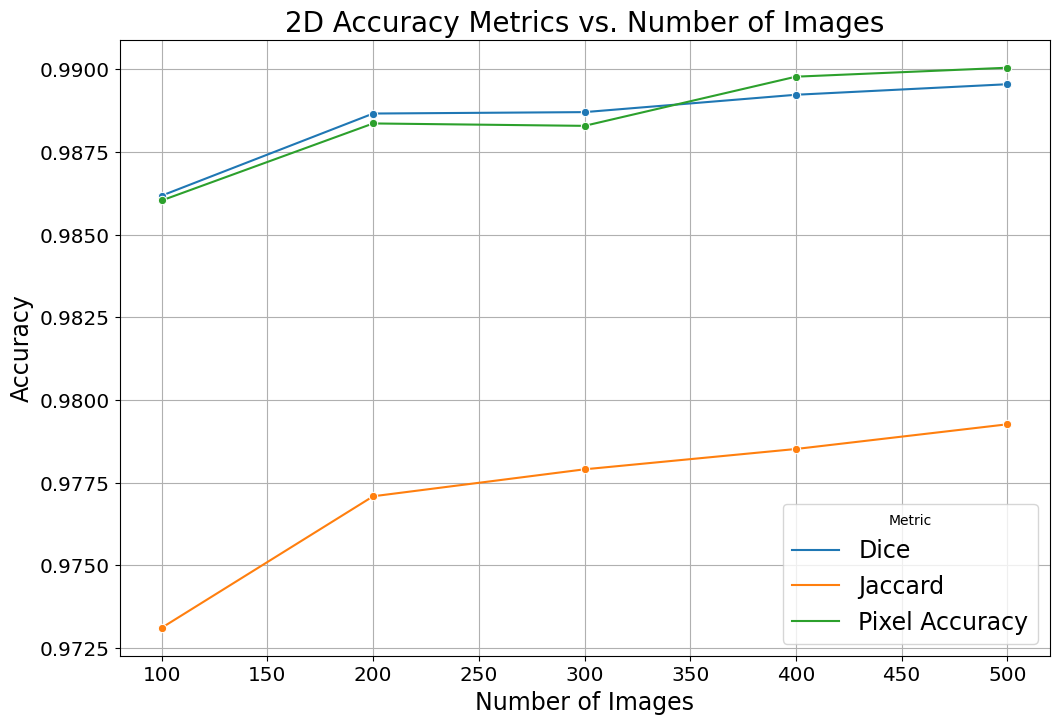

In [ ]:

# Call the plotting function
plot_results(results)